# Lab 10: Non-negative Matrix Factorization

The goal of this lab session is to code a NMF algorithm and use it in some applications.

The lab material was prepared by Prof. Nora Ouzir and Lucca Guardiola

We begin with the standard imports:

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

# NMF - Recap

Non-negative Matrix Factorization is a model where a matrix X is factorized into two matrices W and H, with the property that all three matrices have no negative elements. This non-negativity makes the resulting matrices easier to interpret.


Loss (Regularized Froebnius): $\mathcal{L}(W, H) = \frac{1}{2}\|X-W H\|_{F}^{2}+ \color{red}{\frac{\mu}{2}\|H\|_{F}^{2}+\lambda\|H\|_{1}+\frac{\nu}{2}\|W\|_{F}^{2}}$

Algorithm (multiplicative updates from [Lee and Seung, 1999] (http://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf)

\begin{array}{c}
W \leftarrow W .* \left(X H^T\right)./W \left(H H^{\top} + {\color{red} \nu I_r}\right) \\
H \leftarrow H .* \left(W^{\top} X - {\color{red} \lambda 1_{r \times n}}\right)./\left((W^{\top} W + {\color{red} \mu I_r})H\right)
\end{array}


.* is the dot product ( in python  : A*B ) 

AB is the matrix product ( in python : A@B )

## Initialization 

The computation time and the convergence of the NMF depends on how you initialize the matrices W and H.
You will implement and compare two types of initialization. 

#### Random initialization : 

$\forall i,j, H^0_{i,j}\sim U_{[0,1]}$ and $ W^0_{i,j}\sim U_{[0,1]} $

Each term of $W^0$ and $H^0$ is sampled with a uniform distribution. Use np.random.random(Matrix_shape)

#### NNDSVD initialization : 

Singular value decomposition (SVD) is a classical method that extends the eigen-decomposition to non-square matrix.

For any $ X \in \mathbb{R}^{N\times M}$, there exists a factorization with the following form:

$$ X = U \Sigma V^T $$

With $ U \in \mathbb{R}^{N\times N} , \Sigma  \in \mathbb{R}^{N\times M} \text{ such as } \Sigma = \begin{pmatrix} 
\Sigma_1 & 0 \\
0 & 0 
\end{pmatrix} , V \in \mathbb{R}^{M\times M} $



$\Sigma_1 = diag(σ1, σ2, ..., σr)$, and the diagonal entries are sorted in descending order, i.e. σ1 ≥ σ2 ≥ ... ≥ σr > 0,
σi, i = 1, 2, ...r being the singular values with r = rank(Z)


After the computation of the SVD of X, the initialization of W and H is made with  

$$ W^0 = |U_{:,:r}|$$
$$ H^0 = | \Sigma_{:r,:}V^T| $$ 
$|.|$ means the absolute value for each term of the matrix, r = number of components of the NMF :

You will need : 
np.linalg.svd 

Watch out np.linalg.svd returns only the diagonal of $\Sigma$. I advise you ton create a empty matrix $\Sigma$ with np.zeros(Shape of the matrix) then fill the diagonal with np.diag(). You can use the exemple in https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html



### Tasks  :  
- Fill the fit transform function. Consider $\mathcal{L}(W, H) = \frac{1}{2}\|X-W H\|_{F}^{2}$ (no regularization)
- Implement NNSVD initialization and random initialization. 
- Return W H and the Froebenius norm of the residuals (the loss) when the convergence condition is fulfilled.

(This should take you less than 30 minutes)

In [54]:
np.random.seed(2)

In [58]:
class my_NMF():
    
    def __init__(self, n_components, epsilon,init, max_iter = 60):
        '''
        Attributes:
        
        n_components_ : integer
            the unknown dimension of W and H
        max_iter_: integer
            maximum number of iterations
        epsilon_ : float
        init_ :  {"random", "NNDSVD"}
        w_: np.array
            W Matrix factor
        H_: np.array
            H Matrix factor
        '''
        self.n_components_ = n_components
        self.max_iter_ = max_iter
        self.loss = 0
        self.epsilon_ = epsilon
        self.init = init
        self.W = None
        self.H = None
        
        
    def fit_transform(self, X):
        """ Find the factor matrices W and H
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        W,H,loss
        """        


        
        
        if self.init == 'NNDSVD' : 
            #Initialize W and H with a SVD of X
            u, s, vh = np.linalg.svd(X)
            W = np.abs(u[:,:self.n_components_])
            
            smat = np.zeros((u.shape[0],vh.shape[0]))
            smat[:u.shape[0],:u.shape[0]] = np.diag(s)
            H = smat[:self.n_components_,:]@vh
            
        elif self.init == 'random' :
            #Initialize W and H by generating uniform samples.
            W = np.random.random((X.shape[0], self.n_components_))
            H = np.random.random((self.n_components_, X.shape[1]))
        
        convergence = False 
        c = 0
        while not(convergence) : 
            c += 1
            #The convergence is reached when the number of iteration is equal to self.max_iter or
            #when the loss < self.epsilon
            
            W = W * (X@H.T) / (W@H@H.T)
            H = H*(W.T@X)/(W.T@W@H)
            norm = np.sum((X-W@H)**2)
            print(norm)
            
            if norm < self.epsilon_ or self.max_iter_ == c:
                print('iter =' + str(c))
                print('norm =' + str(norm))
                convergence = True
             
            #Update W and H for each iteration
            
        self.W = W
        self.H = H
        self.loss = norm
        
        return self.W,self.H,self.loss


### Bonus : Implement the regularized version

## Applications

### First application - Images

For the first application you are going to analyse the following data to give an interpretation of the factorization:

(400, 4096)

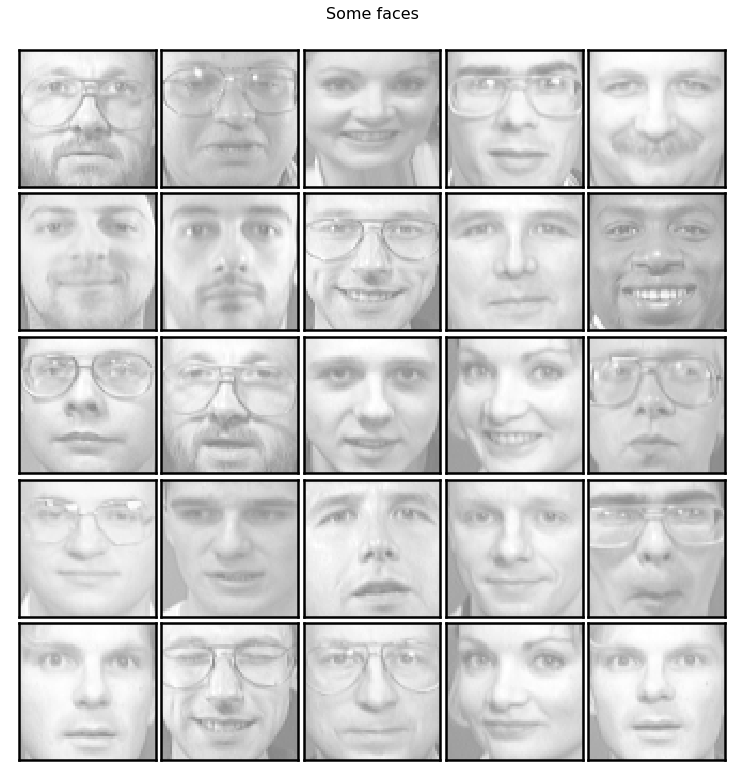

In [59]:
from sklearn.datasets import fetch_olivetti_faces

dataset = fetch_olivetti_faces(shuffle=True)

faces = dataset.data
image_shape = (64, 64)

n_samples, n_features = faces.shape

def plot_faces(title, images, image_shape, n_col=5, n_row=5, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    
plot_faces("Some faces", faces[:25], image_shape)

faces.shape

### Task : apply your NMF algorithm to this dataset and plot the approximated face pictures. Compare the different initializations

In [60]:
NMF_model = my_NMF(36, 0.001, 'random', 500)
W,H,loss = NMF_model.fit_transform(faces)

26282.087301404266
26147.18840630737
26065.4551925401
25986.26098766805
25908.950106992866
25832.888665935312
25757.449441916124
25681.998789861973
25605.884244740926
25528.422623968723
25448.8885596019
25366.503525557422
25280.4255887142
25189.74031563988
25093.453518649236
24990.48683224027
24879.677472452597
24759.7839321799
24629.49976662513
24487.47795161728
24332.368432405867
24162.87124388254
23977.806743163455
23776.202795747195
23557.395989082877
23321.14008325053
23067.71027890613
22797.987361477728
22513.502850574143
22216.426819805823
21909.48568897235
21595.808437517157
21278.71461323134
20961.472192152058
20647.062648222058
20337.99054014602
20036.16488892301
19742.862926834307
19458.76919116418
19184.06983593718
18918.57630978044
18661.85393776258
18413.337039973103
18172.420022027967
17938.521007659674
17711.119780124616
17489.77477782293
17274.124985819268
17063.882356561357
16858.819450978248
16658.75576268031
16463.544970888892
16273.06432949807
16087.206611520645
15

6311.978888562559
6310.118958804628
6308.270243127018
6306.432647090365
6304.606077157788
6302.7904406850075
6300.985645910572
6299.191601946286
6297.408218767799
6295.635407205322
6293.873078934611
6292.121146468006
6290.379523145724
6288.648123127279
6286.92686138308
6285.215653686197
6283.5144166042855
6281.823067491705
6280.141524481738
6278.469706479026
6276.807533152116
6275.154924926189
6273.511802975935
6271.878089218523
6270.253706306788
6268.638577622462
6267.0326272696275
6265.435780068197
6263.847961547603
6262.269097940528
6260.699116176774
6259.137943877233
6257.585509347935
6256.041741574231
6254.506570214986
6252.97992559692
6251.461738708978
6249.951941196807
6248.450465357224
6246.957244132847
6245.472211106658
6243.995300496733
6242.526447150877
6241.065586541466
6239.612654760119
6238.16758851261
6236.730325113635
6235.3008024816845
iter =500
norm =6235.3008024816845


### Tasks :  
- Apply NMF with the SVD initialisation and with a number of components r such as $\sqrt r$ is an integer (r = 4,16,etc..) 
- Plot the $H$ matrix as images in a $(\sqrt{r}, \sqrt{r})$ grid ( n_col=n_row=$\sqrt r $)
- Choose one face, plot its corresponding weights (in $W$) in a grid 
- How can we interpret the matrices H and W.

Be careful with the arguments image_shape, n_col n_row in the plot_faces function

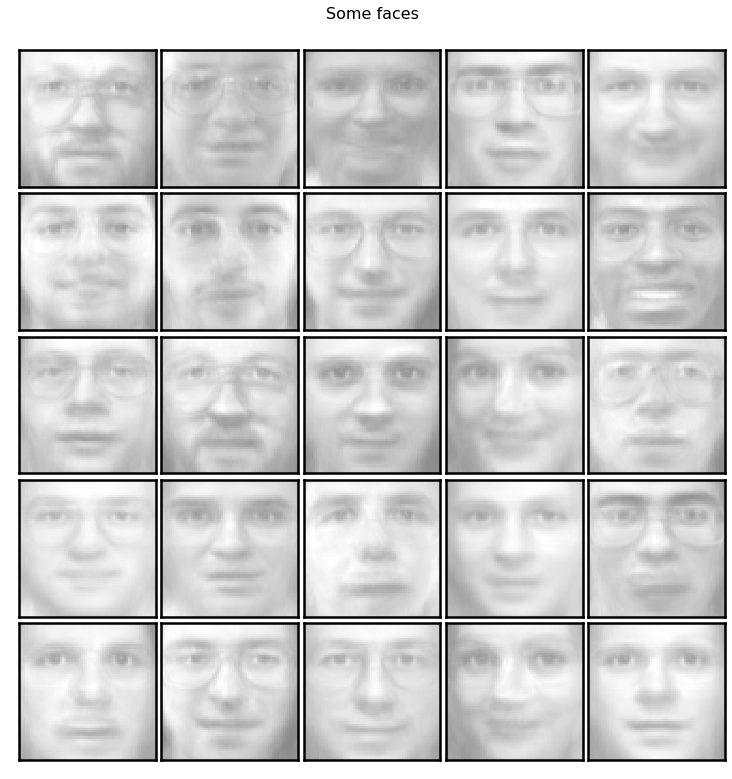

In [61]:
plot_faces("Some faces", (W@H).reshape(faces.shape[0],64*64)[:25], image_shape)

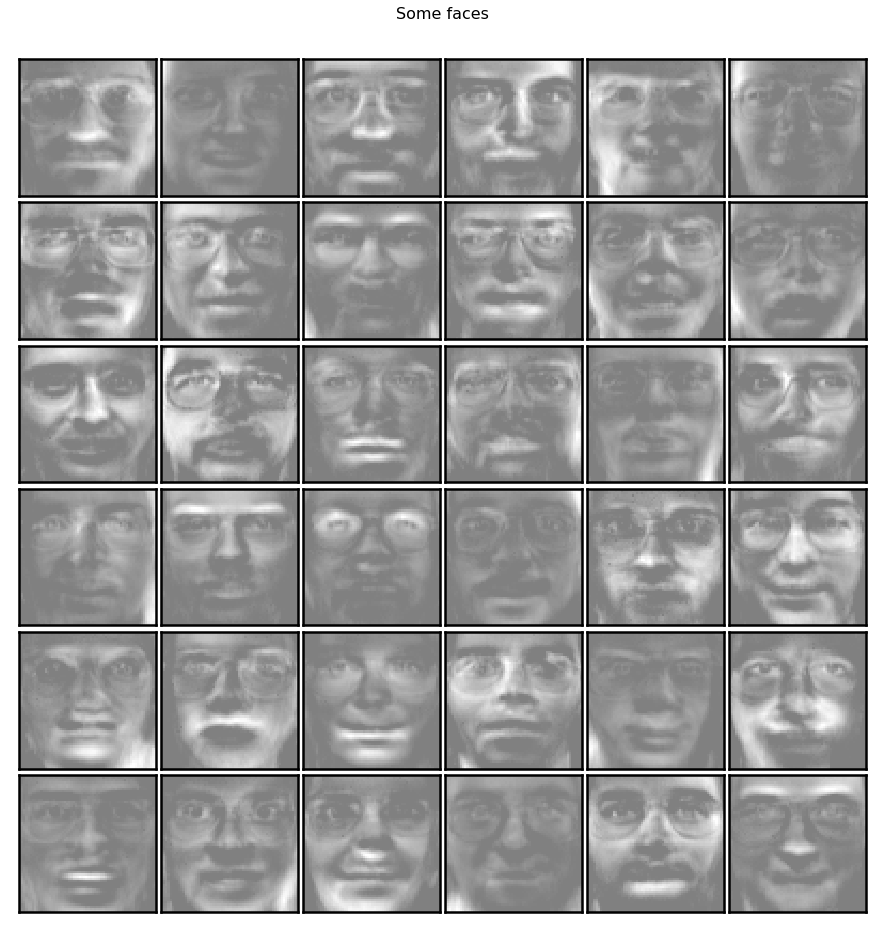

In [62]:
plot_faces("Some faces", H, 
           (64,64), n_col = 6, n_row = 6)

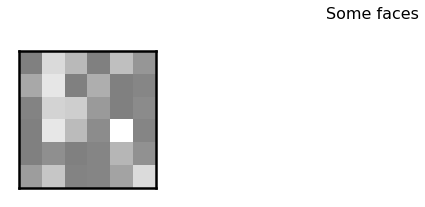

In [65]:
plot_faces("Some faces", W[0,:].reshape(1,36), (6,6))

### Second application

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 news documents from 20 different newsgroups (i.e 20 different topics like art news, geopolitical news etc...)

The goal of this exercice is to model the topics present with NMF then print the most common words of each topic.

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups

n_samples = 5000
n_features = 2000
n_components = 10
n_top_words = 20

def print_top_words(D, feature_names, n_top_words):
    p, r = D.shape
    for topic_idx in range(r):
        topic = D[:, topic_idx]
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data[:n_samples]


print(data_samples[:3]) # A few exemple of news 

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n", "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap 

### Feature extraction/engineering 

Before applying NMF, you have to convert text into numerical values in order to vectorize your documents.

We will be looking at the Count vectorizer method and the TF-IDF vectorizer.

### Count vectorizer. 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

We define a corpus by an ensemble of documents $(D_1,...D_N)$. From this corpus we collect all the different words used in the documents, this collection of words $(w_1,...w_p)$ is called the vocabulary of the corpus.

Using the count vectorizer, the numerical representation of a document $D_i$ will be Count_Vectoriser$(D_i) = \sum_{j=1}^p f_{ij}w_j $ With f_ij, the frequency of appearence of the word $w_j$ in the document $i$.

### TF-IDF

Task : Search for TF-IDF. Explain its principle and its difference with count_vectorizer

Answer : 



### Task : Vectorize your document with Count Vectorizer or TF-IDF. 
#### Put in argument stop_words='english'  and max_features=n_features 
Stop_words is a list of common words that don't bring any information like 'the', 'a' etc... We don't want these words to take up space in our database for computation time reason and because they could harm the numerical representation of the documents. 

You must obtain a $5000\times2000$ shaped matrix 

In [68]:
tfidf_vectorizer = TfidfVectorizer(max_features = n_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data_samples)


### Task : Apply NMF from sklearn with a choosen initialization. Then print the top words for each topics with print_top_words

Use tfidf_vectorizer.get_feature_names() to recover the words. 

In [71]:
from sklearn.decomposition import NMF

In [77]:
NMF_model = NMF(20, init = 'nndsvd', max_iter = 1000)
W = NMF_model.fit_transform(tfidf)
print_top_words(NMF_model.components_.T, tfidf_vectorizer.get_feature_names(), n_top_words)

Topic #0: people government gun right law did said rights make guns point crime state time say evidence case let person believe
Topic #1: thanks mail advance hi info looking email information interested post help know appreciated send address reply anybody hello need list
Topic #2: god jesus bible faith christians christ christian believe church lord heaven life love say father son true good sin belief
Topic #3: key chip encryption keys clipper government escrow law security public enforcement nsa phone algorithm encrypted bit data secure chips des
Topic #4: edu ftp internet pub university article cs cc mit send mail zip email david subject address export available reply gif
Topic #5: car bike new good cars engine power miles time price like used insurance dealer year tires oil buy speed ride
Topic #6: windows file dos files program ms problem running run os swap using directory problems ftp version win nt manager microsoft
Topic #7: game team year games play players season hockey leag

The relevance of the topics can be improved with better parameters in the vectorizer, a more advanced cleaning in addition to the stopwords (for instance getting rid of the numbers etc ...) or more advanced vectorizer/encoder like Word2Vec or Doc2Vec which use very simple neural networks. 

### Imagine we would like to gather the news coming from the same newsgroup/news category. How would you do using the NMF and the previous courses ? 

Answer : Use a classification model with this new space we created. 


### Implement your solution.